In [1]:
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import src.preprocessing as pp
from src.metrics import accuracy_score, confusion_matrix, plot_history
from src.models import *

2024-05-07 19:59:13.673157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
M, F = pp.get_poems()
xt, xv, yt, yv = pp.train_val_split(M, F, 'poem_no_punct', 'gender', random_seed=2024)

In [3]:
enc = Encoder()

yt_ohe = enc.fit_transform(yt)
yv_ohe = enc.transform(yv)
num_classes = len(enc.categories_)

In [ ]:
BATCH_SIZE = 64

train_dataset = Dataset.from_tensor_slices((xt.values, yt_ohe))
val_dataset = Dataset.from_tensor_slices((xv.values, yv_ohe))

train_batches = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_batches = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
text_vectorizer = layers.TextVectorization(standardize=None, split='whitespace')
text_vectorizer.adapt(xt.values)
vocab = text_vectorizer.get_vocabulary()

In [ ]:
# Hyperparameters
learning_rate = 0.0002
optimizer = optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha = 0.10, gamma=3)
epochs = 50

# Architecture
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = layers.Embedding(input_dim=len(vocab),
                                   output_dim=128,
                                   mask_zero=True,
                                   name='token_embedding')(x)
x = layers.Dropout(0.5)(x)

x = layers.Bidirectional(layers.SimpleRNN(128, return_sequences=True))(x)
x = layers.Dropout(0.4)(x)
x = layers.BatchNormalization()(x)

x = layers.SimpleRNN(64, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

x = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, None)      │          0 │ input_layer_1[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, None, 128) │    331,136 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 128) │          0 │ token_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, None)      │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 256) │     65,792 │ dropout_4[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 256) │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 256) │      1,024 │ dropout_5[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_3        │ (None, None, 64)  │     20,544 │ batch_normalizat… │
│ (SimpleRNN)         │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, None, 64)  │          0 │ simple_rnn_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ dropout_6[0][0],  │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32)        │     10,368 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         66 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 429,186 (1.64 MB)

 Trainable params: 428,546 (1.63 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
filepath = "models/temp.keras"

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

# Train the model with the ModelCheckpoint callback
history = model.fit(train_batches,
          validation_data=val_batches,
          epochs=epochs,
          shuffle=True,
          callbacks=[checkpoint])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.5161 - loss: 0.0528
Epoch 1: val_accuracy improved from -inf to 0.71622, saving model to models/temp.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 980ms/step - accuracy: 0.5234 - loss: 0.0522 - val_accuracy: 0.7162 - val_loss: 0.0364
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.7150 - loss: 0.0416
Epoch 2: val_accuracy improved from 0.71622 to 0.75676, saving model to models/temp.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 823ms/step - accuracy: 0.7182 - loss: 0.0415 - val_accuracy: 0.7568 - val_loss: 0.0334
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.7721 - loss: 0.0380
Epoch 3: val_accuracy improved from 0.75676 to 0.77027, saving model to models/temp.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 817ms/step - accuracy: 0.7716 - loss: 0.0379 - val_accuracy: 0.7703 - val_loss: 0.0350
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.7431 - loss: 0.0325
Epoch 4: val_accuracy improved from 0.77027 to 0.78

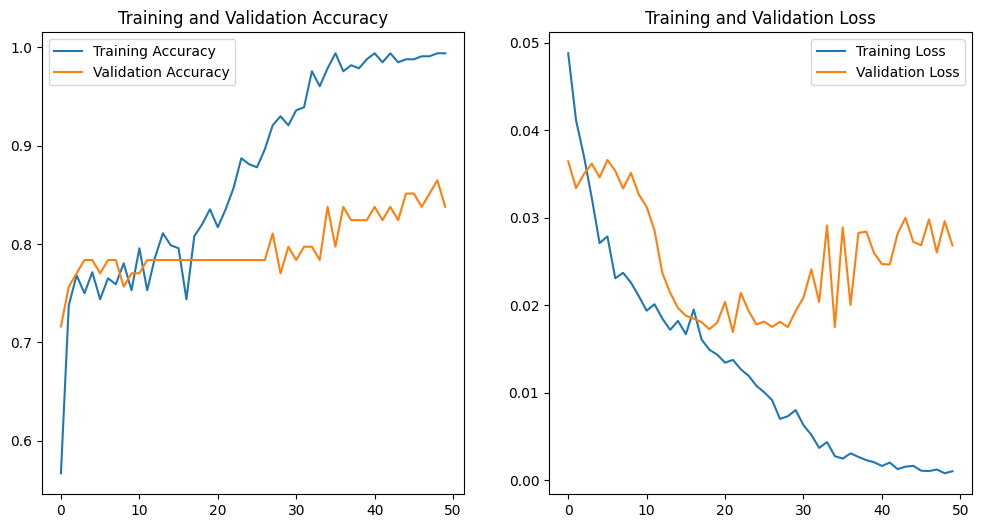

In [ ]:
plot_history(history)

In [4]:
model = tf.keras.models.load_model('models/RNN.keras')

In [5]:
yhat_ohe = model.predict(xv)
yhat = enc.inverse_transform(yhat_ohe)
np.array(yhat)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step


array(['M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M',
       'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M', 'M',
       'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'M',
       'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M'], dtype=object)

In [6]:
yhat_ohe[10:20]

array([[0.06135735, 0.93864256],
       [0.07417806, 0.92582196],
       [0.07145951, 0.92854047],
       [0.06371646, 0.9362835 ],
       [0.05867488, 0.9413251 ],
       [0.06524549, 0.93475443],
       [0.58214104, 0.417859  ],
       [0.06083524, 0.93916476],
       [0.05748706, 0.9425128 ],
       [0.05548368, 0.9445163 ]], dtype=float32)

In [7]:
accuracy_score(yv, yhat)

0.8648648648648649

In [8]:
confusion_matrix(yv, yhat)

array([[ 9,  7],
       [ 3, 55]])

In [15]:
df = pd.concat([M, F]).sample(frac=1).reset_index(drop=True).reset_index()[['index', 'gender', 'poem_no_punct', 'length']]
df

,index,gender,poem_no_punct,length
0,0,M,昔 人 已 乘 黃 鶴 去 _ 此 地 空 餘 黃 鶴 樓 _ 黃 鶴 一 去 不 復 返 ...,63
1,1,F,神 功 不 测 兮 运 阴 阳 _ 包 藏 万 宇 兮 孕 八 荒 _ 天 符 既 出 兮 ...,35
2,2,M,長 簟 迎 風 早 _ 空 城 澹 月 華 _ 星 河 秋 一 雁 _ 砧 杵 夜 千 家 ...,47
3,3,F,人 道 海 水 深 _ 不 抵 相 思 半 _ 海 水 尚 有 涯 _ 相 思 渺 無 畔 ...,47
4,4,M,艷 色 天 下 重 _ 西 施 寧 久 微 _ 朝 為 越 溪 女 _ 暮 作 吳 宮 妃 ...,83
...,...,...,...,...
397,397,F,笙 镛 间 玉 宇 _ 文 物 昭 清 晖 _ 睟 影 临 芳 奠 _ 休 光 下 太 微 ...,35
398,398,M,北 風 捲 地 白 草 折 _ 胡 天 八 月 即 飛 雪 _ 忽 如 一 夜 春 風 來 ...,143
399,399,M,積 雨 空 林 煙 火 遲 _ 蒸 藜 炊 黍 餉 東 菑 _ 漠 漠 水 田 飛 白 鷺 ...,63
400,400,M,雲 母 屏 風 燭 影 深 _ 長 河 漸 落 曉 星 沈 _ 嫦 娥 應 悔 偷 靈 藥 ...,31


In [16]:
tfidf = load_tfidf_svc()

df['tfidf'] = tfidf.predict(df['poem_no_punct'])

Predicting TF-IDF ...


In [17]:
rnn = tf.keras.models.load_model('models/RNN.keras')

rnn_preds = rnn.predict(df['poem_no_punct'])
rnn_res = enc.inverse_transform(rnn_preds)

df['rnn'] = rnn_res
df['rnn_prob'] = [x[0] for x in rnn_preds]

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


In [18]:
df

,index,gender,poem_no_punct,length,tfidf,rnn,rnn_prob
0,0,M,昔 人 已 乘 黃 鶴 去 _ 此 地 空 餘 黃 鶴 樓 _ 黃 鶴 一 去 不 復 返 ...,63,M,M,0.064395
1,1,F,神 功 不 测 兮 运 阴 阳 _ 包 藏 万 宇 兮 孕 八 荒 _ 天 符 既 出 兮 ...,35,F,F,0.927119
2,2,M,長 簟 迎 風 早 _ 空 城 澹 月 華 _ 星 河 秋 一 雁 _ 砧 杵 夜 千 家 ...,47,M,M,0.063716
3,3,F,人 道 海 水 深 _ 不 抵 相 思 半 _ 海 水 尚 有 涯 _ 相 思 渺 無 畔 ...,47,F,F,0.823564
4,4,M,艷 色 天 下 重 _ 西 施 寧 久 微 _ 朝 為 越 溪 女 _ 暮 作 吳 宮 妃 ...,83,M,M,0.063959
...,...,...,...,...,...,...,...
397,397,F,笙 镛 间 玉 宇 _ 文 物 昭 清 晖 _ 睟 影 临 芳 奠 _ 休 光 下 太 微 ...,35,F,F,0.732214
398,398,M,北 風 捲 地 白 草 折 _ 胡 天 八 月 即 飛 雪 _ 忽 如 一 夜 春 風 來 ...,143,M,M,0.061002
399,399,M,積 雨 空 林 煙 火 遲 _ 蒸 藜 炊 黍 餉 東 菑 _ 漠 漠 水 田 飛 白 鷺 ...,63,M,M,0.065576
400,400,M,雲 母 屏 風 燭 影 深 _ 長 河 漸 落 曉 星 沈 _ 嫦 娥 應 悔 偷 靈 藥 ...,31,M,M,0.061657


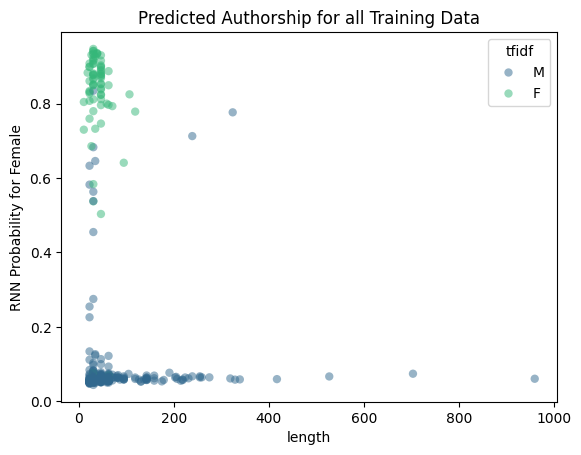

In [25]:
# tfidf_F = df[df['tfidf'] == 'F']
sns.scatterplot(x='length', y='rnn_prob', data=df, hue='tfidf', palette='viridis', linewidth=0, alpha=0.5)
plt.title('Predicted Authorship for all Training Data')
plt.ylabel('RNN Probability for Female')
plt.show()

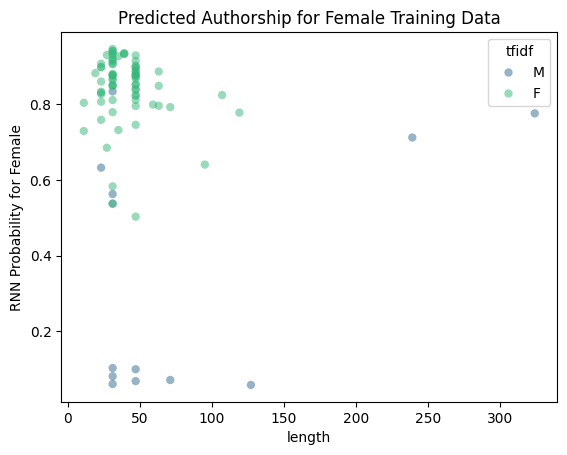

In [27]:
df_F = df[df['gender'] == 'F'].sort_values('tfidf', ascending=False)
sns.scatterplot(x='length', y='rnn_prob', data=df_F, hue='tfidf', palette='viridis', linewidth=0, alpha=0.5)
plt.title('Predicted Authorship for Female Training Data')
plt.ylabel('RNN Probability for Female')
plt.show()